In [ ]:
# import dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import hvplot.pandas
from scipy.stats import linregress
import json

In [ ]:
# CSV file path, read and print sample 
file_path = "../Resources/VAERSDATA1 (3).csv"
covid_df = pd.read_csv(file_path)
covid_df.sample(20)

,VAERS_ID,RECVDATE,STATE,AGE_YRS,SEX,DIED,DATEDIED,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,V_ADMINBY,VAX_MANU,HISTORY,ALLERGIES
244134,950984,1/17/2021,PA,37,F,NaN,NaN,N,1/15/2021,1/15/2021,0.0,PVT,MODERNA,NaN,Lactose intolerance
691627,2671595,8/15/2023,OH,67,M,NaN,NaN,U,8/9/2023,8/9/2023,0.0,PVT,PFIZER\BIONTECH,"HTN, Type 2 Diabetes",NKDA
282028,2127055,2/19/2022,NC,39,F,NaN,NaN,N,4/14/2021,4/14/2021,0.0,PUB,PFIZER\BIONTECH,Medical History/Concurrent Conditions: Menstru...,NaN
394527,1182861,4/8/2021,CA,48,M,NaN,NaN,Y,4/8/2021,4/8/2021,0.0,PUB,PFIZER\BIONTECH,NaN,NaN
852390,2497358,1/24/2021,NaN,82,M,NaN,NaN,U,1/15/2021,1/15/2021,0.0,OTH,MODERNA,NaN,NaN
397215,1423642,6/24/2021,KS,48,M,NaN,NaN,Y,6/8/2021,6/10/2021,2.0,PVT,MODERNA,"Obesity, chronic pain",seasonal
172795,1565001,8/15/2021,OR,31,F,NaN,NaN,N,3/6/2021,3/7/2021,1.0,UNK,MODERNA,NaN,NaN
624816,2271229,5/11/2022,CA,63,F,NaN,NaN,N,10/24/2021,10/25/2021,1.0,PVT,PFIZER\BIONTECH,NaN,NaN
761145,2442956,9/13/2022,OH,72,F,NaN,NaN,NaN,9/13/2022,9/13/2022,0.0,PUB,MODERNA,NaN,NaN
458984,2006401,1/5/2022,MD,52,F,NaN,NaN,N,1/3/2022,1/3/2022,0.0,PHM,PFIZER\BIONTECH,No long-standing health conditions,No allergies


In [ ]:
# Dropping columns I know that are not needed for data I am after
covid_df.drop(['NUMDAYS', 'V_ADMINBY', 'HISTORY', 'ALLERGIES'], axis=1, inplace=True)

# Display
covid_df.head()


,VAERS_ID,RECVDATE,STATE,AGE_YRS,SEX,DIED,DATEDIED,RECOVD,VAX_DATE,ONSET_DATE,VAX_MANU
0,1021156,2/10/2021,IL,32,F,NaN,NaN,N,1/27/2021,2/4/2021,MODERNA
1,1029567,2/14/2021,NH,61,M,NaN,NaN,U,2/14/2021,2/14/2021,MODERNA
2,1061353,2/28/2021,WA,74,M,NaN,NaN,N,2/24/2021,2/24/2021,PFIZER\BIONTECH
3,1066793,3/2/2021,AZ,81,M,NaN,NaN,N,2/12/2021,2/26/2021,PFIZER\BIONTECH
4,1219181,4/16/2021,TX,15,M,NaN,NaN,Y,4/15/2021,4/15/2021,PFIZER\BIONTECH


In [ ]:
# #total count of vaccines administered by manufacturer
vaccine_counts = covid_df.groupby('VAX_MANU').size().reset_index(name='Total_Vaccines_Administered')


# Add a total count row for all vaccines administered
total_vaccines = vaccine_counts['Total_Vaccines_Administered'].sum()
total_row = pd.DataFrame([["TOTAL", total_vaccines]], columns=vaccine_counts.columns)

# Append, or concat the total row
vaccine_counts = pd.concat([vaccine_counts, total_row], ignore_index=True)

# Display 
vaccine_counts



,VAX_MANU,Total_Vaccines_Administered
0,JANSSEN,53687
1,MODERNA,408657
2,NOVAVAX,300
3,PFIZER\BIONTECH,413910
4,UNKNOWN MANUFACTURER,19975
5,TOTAL,896529


In [ ]:
# Adverse Reactions (cases where 'RECOVD' is NOT 'Y')
adverse_reactions_df = covid_df[(covid_df['RECOVD'] != 'Y')]

# Unknown Cases (cases where 'RECOVD' == 'U')
unknown_cases_df = covid_df[covid_df['RECOVD'] == 'U']

# Separate deaths
deaths_df = covid_df[covid_df['DIED'] == 'Y']

# Group by manufacturer for adverse reactions
adverse_reactions_by_manufacturer = adverse_reactions_df.groupby('VAX_MANU').size().reset_index(name='Adverse_Reactions')

# Group by manufacturer for deaths
deaths_by_manufacturer = deaths_df.groupby('VAX_MANU').size().reset_index(name='Deaths')

# Group by manufacturer for unknown cases
unknown_cases_by_manufacturer = unknown_cases_df.groupby('VAX_MANU').size().reset_index(name='Unknown_Cases')

# Merge all summaries
summary_df = adverse_reactions_by_manufacturer.merge(deaths_by_manufacturer, on='VAX_MANU', how='outer').merge(
    unknown_cases_by_manufacturer, on='VAX_MANU', how='outer'
).fillna(0)

# Convert to integers
summary_df[['Adverse_Reactions', 'Deaths', 'Unknown_Cases']] = summary_df[['Adverse_Reactions', 'Deaths', 'Unknown_Cases']].astype(int)

# Calculate Unknown Percentage
summary_df['Unknown_Percentage'] = (summary_df['Unknown_Cases'] / summary_df['Adverse_Reactions']) * 100
summary_df['Unknown_Percentage'] = summary_df['Unknown_Percentage'].fillna(0).round(2)  # Round to 2 decimal places

# Calculate total row
total_adverse_reactions = summary_df['Adverse_Reactions'].sum()
total_deaths = summary_df['Deaths'].sum()
total_unknown_cases = summary_df['Unknown_Cases'].sum()

# Avoid division by zero
total_unknown_percentage = (total_unknown_cases / total_adverse_reactions) * 100 if total_adverse_reactions > 0 else 0

# Create the total row
total_row = pd.DataFrame([{
    'VAX_MANU': 'TOTAL',
    'Adverse_Reactions': total_adverse_reactions,
    'Deaths': total_deaths,
    'Unknown_Cases': total_unknown_cases,
    'Unknown_Percentage': round(total_unknown_percentage, 2)
}])

# Append the total row to summary_df
summary_df = pd.concat([summary_df, total_row], ignore_index=True)

# Display the updated summary DataFrame
summary_df


,VAX_MANU,Adverse_Reactions,Deaths,Unknown_Cases,Unknown_Percentage
0,JANSSEN,35521,1317,9065,25.52
1,MODERNA,268139,7563,90090,33.60
2,NOVAVAX,218,0,49,22.48
3,PFIZER\BIONTECH,287050,7403,76315,26.59
4,UNKNOWN MANUFACTURER,13543,623,3995,29.50
5,TOTAL,604471,16906,179514,29.70


In [26]:
# Merge vaccine counts with adverse reactions data
adverse_percentage_df = vaccine_counts.merge(adverse_reactions_by_manufacturer, on='VAX_MANU', how='left').fillna(0)

# Convert columns to integers to avoid float representation issues
adverse_percentage_df[['Total_Vaccines_Administered', 'Adverse_Reactions']] = adverse_percentage_df[['Total_Vaccines_Administered', 'Adverse_Reactions']].astype(int)

# Calculate Adverse Reaction Percentage safely
adverse_percentage_df['Adverse_Reaction_Percentage'] = (
    (adverse_percentage_df['Adverse_Reactions'] / adverse_percentage_df['Total_Vaccines_Administered']) * 100
).replace([np.inf, -np.inf], 0).fillna(0).round(2)

# Fix the TOTAL row manually
total_vaccines = adverse_percentage_df.loc[adverse_percentage_df['VAX_MANU'] != 'TOTAL', 'Total_Vaccines_Administered'].sum()
total_adverse_reactions = adverse_percentage_df.loc[adverse_percentage_df['VAX_MANU'] != 'TOTAL', 'Adverse_Reactions'].sum()

# Avoid division by zero
total_adverse_percentage = (total_adverse_reactions / total_vaccines) * 100 if total_vaccines > 0 else 0

# Update the total row in the DataFrame
adverse_percentage_df.loc[adverse_percentage_df['VAX_MANU'] == 'TOTAL', 'Total_Vaccines_Administered'] = total_vaccines
adverse_percentage_df.loc[adverse_percentage_df['VAX_MANU'] == 'TOTAL', 'Adverse_Reactions'] = total_adverse_reactions
adverse_percentage_df.loc[adverse_percentage_df['VAX_MANU'] == 'TOTAL', 'Adverse_Reaction_Percentage'] = round(total_adverse_percentage, 2)

# Display the updated DataFrame
adverse_percentage_df


,VAX_MANU,Total_Vaccines_Administered,Adverse_Reactions,Adverse_Reaction_Percentage
0,JANSSEN,53687,35521,66.16
1,MODERNA,408657,268139,65.61
2,NOVAVAX,300,218,72.67
3,PFIZER\BIONTECH,413910,287050,69.35
4,UNKNOWN MANUFACTURER,19975,13543,67.80
5,TOTAL,896529,604471,67.42


In [27]:
# Ensure 'Deaths' data is included
death_percentage_df = vaccine_counts.merge(deaths_by_manufacturer, on='VAX_MANU', how='left').fillna(0)

# Convert to integers to avoid float representation issues
death_percentage_df[['Total_Vaccines_Administered', 'Deaths']] = death_percentage_df[['Total_Vaccines_Administered', 'Deaths']].astype(int)

# Correctly calculate Deaths Percentage
death_percentage_df['Deaths_Percentage'] = (
    (death_percentage_df['Deaths'] / death_percentage_df['Total_Vaccines_Administered']) * 100
).replace([np.inf, -np.inf], 0).fillna(0).round(2)

# Fix the TOTAL row manually
total_vaccines = death_percentage_df.loc[death_percentage_df['VAX_MANU'] != 'TOTAL', 'Total_Vaccines_Administered'].sum()
total_deaths = death_percentage_df.loc[death_percentage_df['VAX_MANU'] != 'TOTAL', 'Deaths'].sum()

# Avoid division by zero when calculating the total percentage
total_death_percentage = (total_deaths / total_vaccines) * 100 if total_vaccines > 0 else 0

# Ensure TOTAL row exists, and update it
if 'TOTAL' not in death_percentage_df['VAX_MANU'].values:
    total_row = pd.DataFrame([{
        'VAX_MANU': 'TOTAL',
        'Total_Vaccines_Administered': total_vaccines,
        'Deaths': total_deaths,
        'Deaths_Percentage': round(total_death_percentage, 2)
    }])
    death_percentage_df = pd.concat([death_percentage_df, total_row], ignore_index=True)
else:
    death_percentage_df.loc[death_percentage_df['VAX_MANU'] == 'TOTAL', 'Total_Vaccines_Administered'] = total_vaccines
    death_percentage_df.loc[death_percentage_df['VAX_MANU'] == 'TOTAL', 'Deaths'] = total_deaths
    death_percentage_df.loc[death_percentage_df['VAX_MANU'] == 'TOTAL', 'Deaths_Percentage'] = round(total_death_percentage, 2)

# Display the updated DataFrame
death_percentage_df





,VAX_MANU,Total_Vaccines_Administered,Deaths,Deaths_Percentage
0,JANSSEN,53687,1317,2.45
1,MODERNA,408657,7563,1.85
2,NOVAVAX,300,0,0.00
3,PFIZER\BIONTECH,413910,7403,1.79
4,UNKNOWN MANUFACTURER,19975,623,3.12
5,TOTAL,896529,16906,1.89


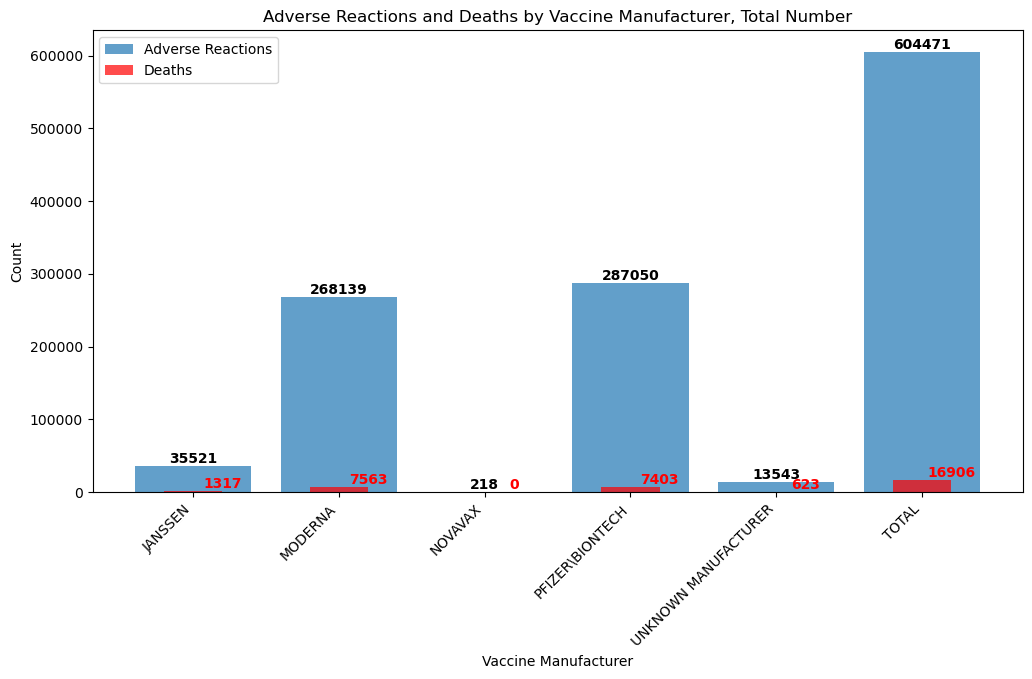

In [28]:
# Adjusting the NOVAVAX bar to separate Adverse Reactions and Deaths more clearly

plt.figure(figsize=(12, 6))
x_labels = summary_df['VAX_MANU']

# Plot Adverse Reactions
bars1 = plt.bar(x_labels, summary_df['Adverse_Reactions'], label="Adverse Reactions", alpha=0.7)

# Plot Deaths slightly offset for clarity
bar_width = 0.4  # Offset width
bars2 = plt.bar(x_labels, summary_df['Deaths'], label="Deaths", alpha=0.7, color='red', width=bar_width)

# Add numbers above the bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=10, fontweight='bold')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 + bar_width/2, yval, int(yval), ha='center', va='bottom', fontsize=10, fontweight='bold', color='red')

# Labels and title
plt.xlabel("Vaccine Manufacturer")
plt.ylabel("Count")
plt.title("Adverse Reactions and Deaths by Vaccine Manufacturer, Total Number")
plt.xticks(rotation=45, ha='right')
plt.legend()

file_path = "adverse_reactions_death_number.png"
plt.savefig(file_path, dpi=300, bbox_inches='tight')

# Show plot
plt.show()


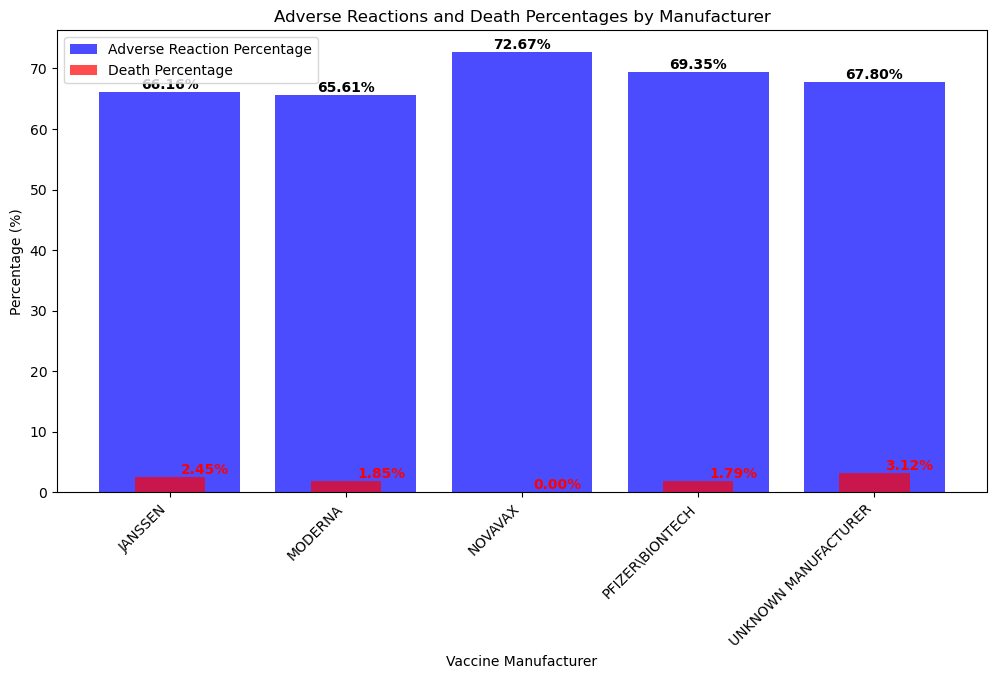

In [29]:
import matplotlib.pyplot as plt

# Merge both percentage data into a single dataframe for plotting
percentage_df = adverse_percentage_df[['VAX_MANU', 'Adverse_Reaction_Percentage']].merge(
    death_percentage_df[['VAX_MANU', 'Deaths_Percentage']], on='VAX_MANU', how='left'
).fillna(0)

# Remove the "Total" row if it exists
percentage_df = percentage_df[percentage_df['VAX_MANU'].str.lower() != 'total']

# Create the bar chart using the merged dataframe
plt.figure(figsize=(12, 6))
x_labels = percentage_df['VAX_MANU']

# Plot Adverse Reactions Percentage
bars1 = plt.bar(x_labels, percentage_df['Adverse_Reaction_Percentage'], label="Adverse Reaction Percentage", alpha=0.7, color='blue')

# Plot Death Percentage slightly offset for clarity
bar_width = 0.4  # Offset width
bars2 = plt.bar(x_labels, percentage_df['Deaths_Percentage'], label="Death Percentage", alpha=0.7, color='red', width=bar_width)

# Add numbers above the bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}%", ha='center', va='bottom', fontsize=10, fontweight='bold')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 + bar_width/2, yval, f"{yval:.2f}%", ha='center', va='bottom', fontsize=10, fontweight='bold', color='red')

# Labels and title
plt.xlabel("Vaccine Manufacturer")
plt.ylabel("Percentage (%)")
plt.title("Adverse Reactions and Death Percentages by Manufacturer")
plt.xticks(rotation=45, ha='right')
plt.legend()

file_path = "adverse_reactions_death_percentages.png"
plt.savefig(file_path, dpi=300, bbox_inches='tight')

# Show plot
plt.show()

